In [1]:
import numpy 
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat
from keras import optimizers

## Convert an array of values into a dataset matrix

In [2]:
def create_dataset(dataset, look_back=1):
    
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-1):
    
        
        a = dataset[i:(i+look_back), 0]
        
        dataX.append(a)
        
        dataY.append(dataset[i + look_back, 0])
        
        
    return numpy.array(dataX), numpy.array(dataY)

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Fix random seed for reproducibility

In [4]:
numpy.random.seed(235)
# load the dataset
df = pd.read_csv('Production.csv',header=0)
df = df[['Bhp', 'Gas']]
dataset = df.values
#dataset = dataset[0:3000]


## Normalize the dataset

In [5]:
dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
look_back = 1
n_features = 2
n_obs = look_back*(n_features-1)+(n_features-1)
reframed = series_to_supervised(dataset, look_back, 1)
print(reframed)
values = reframed.values

# split into train and test sets
train_size = int(len(values) * 0.8)

#train_size = 2000
test_size = len(values) - train_size

train, test = values[0:train_size,:], values[train_size:len(values),:]

     var1(t-1)  var2(t-1)   var1(t)   var2(t)
1     0.001129   0.000000  0.150780  0.452665
2     0.150780   0.452665  1.000000  0.917793
3     1.000000   0.917793  0.897040  1.000000
4     0.897040   1.000000  0.819222  0.945986
5     0.819222   0.945986  0.771333  0.018549
..         ...        ...       ...       ...
268   0.230666   0.387021  0.223826  0.398116
269   0.223826   0.398116  0.210749  0.376872
270   0.210749   0.376872  0.218973  0.395372
271   0.218973   0.395372  0.196849  0.384801
272   0.196849   0.384801  0.234968  0.368846

[272 rows x 4 columns]


  ## Reshape into X = t and Y = t + 1

In [6]:
trainX, trainY = train[:, :n_obs], train[:, -1]
testX, testY = test[:, :n_obs], test[:, -1]

## Reshape input to be [samples, time steps, features]

In [7]:
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back+1, n_features-1))
testX = numpy.reshape(testX, (testX.shape[0], look_back+1, n_features-1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(8, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=16, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/200
14/14 - 3s - loss: 0.2594
Epoch 2/200
14/14 - 0s - loss: 0.2222
Epoch 3/200
14/14 - 0s - loss: 0.1855
Epoch 4/200
14/14 - 0s - loss: 0.1487
Epoch 5/200
14/14 - 0s - loss: 0.1123
Epoch 6/200
14/14 - 0s - loss: 0.0777
Epoch 7/200
14/14 - 0s - loss: 0.0477
Epoch 8/200
14/14 - 0s - loss: 0.0256
Epoch 9/200
14/14 - 0s - loss: 0.0121
Epoch 10/200
14/14 - 0s - loss: 0.0078
Epoch 11/200
14/14 - 0s - loss: 0.0072
Epoch 12/200
14/14 - 0s - loss: 0.0073
Epoch 13/200
14/14 - 0s - loss: 0.0073
Epoch 14/200
14/14 - 0s - loss: 0.0072
Epoch 15/200
14/14 - 0s - loss: 0.0072
Epoch 16/200
14/14 - 0s - loss: 0.0072
Epoch 17/200
14/14 - 0s - loss: 0.0072
Epoch 18/200
14/14 - 0s - loss: 0.0072
Epoch 19/200
14/14 - 0s - loss: 0.0072
Epoch 20/200
14/14 - 0s - loss: 0.0071
Epoch 21/200
14/14 - 0s - loss: 0.0071
Epoch 22/200
14/14 - 0s - loss: 0.0071
Epoch 23/200
14/14 - 0s - loss: 0.0071
Epoch 24/200
14/14 - 0s - loss: 0.0071
Epoch 25/200
14/14 - 0s - loss: 0.0070
Epoch 26/200
14/14 - 0s - loss: 0.

## Invert prediction, scaling for forecast, and scaling for actual

In [8]:
trainX = trainX.reshape((trainX.shape[0], n_obs))

n_f = n_features - 1

inv_ypred = numpy.concatenate((trainX[:,-n_f:],trainPredict), axis=1)

inv_ypred = scaler.inverse_transform(inv_ypred)
inv_ypred = inv_ypred[:,n_f]

trainY = trainY.reshape((len(trainY), 1))
predY = numpy.concatenate((trainX[:,-n_f:],trainY), axis=1)
predY = scaler.inverse_transform(predY)
predY = predY[:,n_f]

## Make a prediction

In [9]:
# make a prediction

testX = testX.reshape((testX.shape[0], n_obs))

## Invert scaling for forecast and actual, and calculate RMSE

In [10]:
inv_yhat = numpy.concatenate((testX[:,-n_f:],testPredict), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,n_f]

testY = testY.reshape((len(testY), 1))
invY = numpy.concatenate((testX[:,-n_f:],testY), axis=1)
invY = scaler.inverse_transform(invY)
invY = invY[:,n_f]

rmse = math.sqrt(mean_squared_error(invY, inv_yhat))
print('Test RMSE: %.8f' % rmse)

Test RMSE: 280.77674071


In [11]:
inv_ypred = inv_ypred.reshape((len(inv_ypred), 1))
predY = predY.reshape((len(predY), 1))
inv_yhat = inv_yhat.reshape((len(inv_yhat), 1))
invY = invY.reshape((len(invY), 1))
plotpredY = numpy.concatenate((inv_ypred, predY), axis=1)
plotactY = numpy.concatenate((inv_yhat, invY), axis=1)

trainPredictPlot = numpy.empty([len(dataset[:,0]),2])
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(plotpredY)+look_back, :] = plotpredY

testPredictPlot = numpy.empty([len(dataset[:,0]),2])
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(plotpredY)+look_back-1:len(dataset)-1, :] = plotactY

In [12]:
# invert scaling for forecast
inv_yhat = numpy.concatenate((testX[:,-n_f:],testPredict), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,n_f]
# invert scaling for actual
testY = testY.reshape((len(testY), 1))
invY = numpy.concatenate((testX[:,-n_f:],testY), axis=1)
invY = scaler.inverse_transform(invY)
invY = invY[:,n_f]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(invY, inv_yhat))
print('Test RMSE: %.8f' % rmse)

Test RMSE: 280.77674071


In [13]:
inv_ypred = inv_ypred.reshape((len(inv_ypred), 1))
predY = predY.reshape((len(predY), 1))
inv_yhat = inv_yhat.reshape((len(inv_yhat), 1))
invY = invY.reshape((len(invY), 1))
plotpredY = numpy.concatenate((inv_ypred, predY), axis=1)
plotactY = numpy.concatenate((inv_yhat, invY), axis=1)

In [14]:
trainPredictPlot = numpy.empty([len(dataset[:,0]),2])
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(plotpredY)+look_back, :] = plotpredY

testPredictPlot = numpy.empty([len(dataset[:,0]),2])
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(plotpredY)+look_back-1:len(dataset)-1, :] = plotactY

## Plotting the results

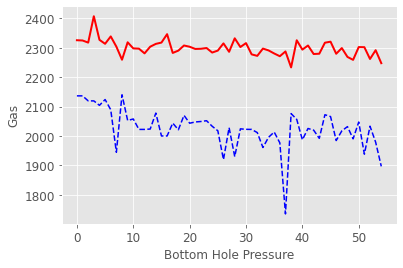

In [16]:
plt.figure(1)
plt.xlabel('Bottom Hole Pressure',fontsize=12)
plt.ylabel('Gas',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(inv_yhat,'r-',label='Predicted',linewidth=2)
plt.plot(invY,'b--',label='Actual')
plt.style.use('ggplot')
plt.show()